# OLCI atmospheric correction effects: Level-1B to Level-2 spectral comparison

    Version: 2.0
    Date:    10/04/2019
    Author:  Ben Loveday and Hayley Evers-King (Plymouth Marine Laboratory)
    Credit:  This code was developed for EUMETSAT under contracts for the Copernicus 
             programme.
    License: This code is offered as free-to-use in the public domain, with no warranty.

This routine shows examples of how to use python netcdf libraries to compare OLCI L1 and L2 spectra, either for a single point or averaged over and area.

You should try the OLCI_spectral_interrogation.ipynb routine prior to using this one. 

We start by import libraries for all the functions we need

In [2]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import fnmatch
import datetime
import logging

Here we define a function to calculate spherical distance between points so that we can define polygons

In [3]:
# function
def spheric_dist(lat1,lat2,lon1,lon2,mode="global"):

    '''
      function dist=spheric_dist(lat1,lat2,lon1,lon2)
      compute distances for a simple spheric earth

      input:
      lat1 : latitude of first point (matrix or point)
      lon1 : longitude of first point (matrix or point)
      lat2 : latitude of second point (matrix or point)
      lon2 : longitude of second point (matrix or point)

      output:
      dist : distance from first point to second point (matrix)
    '''

    R = 6367442.76
    # Determine proper longitudinal shift.
    l = np.abs(lon2-lon1)
    try:
        l[l >= 180] = 360 - l[l >= 180]
    except:
        pass
    # Convert Decimal degrees to radians.
    deg2rad = np.pi/180
    phi1    = (90-lat1)*deg2rad
    phi2    = (90-lat2)*deg2rad
    theta1  = lon1*deg2rad
    theta2  = lon2*deg2rad
 
    lat1    = lat1*deg2rad
    lat2    = lat2*deg2rad
    l       = l*deg2rad

    if mode=="global":
        # Compute the distances: new
        cos     = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + 
                   np.cos(phi1)*np.cos(phi2))
        arc     = np.arccos( cos )
        dist    = R*arc
    elif mode=="regional":
        # Compute the distances: 1 old, deprecated ROMS version - unsuitable for global
        dist    = R*np.arcsin(np.sqrt(((np.sin(l)*np.cos(lat2))**2) + (((np.sin(lat2)*np.cos(lat1)) - \
                  (np.sin(lat1)*np.cos(lat2)*np.cos(l)))**2)))
    elif mode=="local":
        #uses approx for now: 
        x = [lon2-lon1] * np.cos(0.5*[lat2+lat1])
        y = lat2-lat1
        dist = R*[x*x+y*y]^0.5
    else:
        print("incorrect mode")

    return dist

To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder. 

In [9]:
# e.g. MYPATH = os.path.join("C:/","Users","me","Desktop")
MYPATH = "/users/rsg/olcl/scratch/eum_repos/ocean/"

In [5]:
#-default parameters------------------------------------------------------------
DEFAULT_LOG_PATH    = os.getcwd()
DEFAULT_L1_FILE_FILTER = '*radiance*.nc'
DEFAULT_L2_FILE_FILTER = '*reflectance*.nc'

And here we enter the programme proper, setting up our preliminaries and logfile.

In [6]:
#-main-------------------------------------------------------------------------
# preliminary stuff
logfile = os.path.join(DEFAULT_LOG_PATH,"OLCI_spectral_AC_"+datetime.datetime.now().strftime('%Y%m%d_%H%M')+".log")

# we define a verbose flag to control how much info we want to see. It can also be useful to define a debug flag
# for even more information.
verbose = False
    
# set file logger
try:
    if os.path.exists(logfile):
        os.remove(logfile)
    print("logging to: "+logfile)
    logging.basicConfig(filename=logfile,level=logging.DEBUG)
except:
    print("Failed to set logger")

logging to: /local1/data/scratch/eum_repos/ocean/OLCI/OLCI_spectral_AC_20200331_1000.log


Next we define the a box to average our spectra over. If we set the lon values equal, and lat values equal, then we take the spectra from the nearest single point.

In [7]:
# makes box average. Will choose nearest point if latmin == latmax and lonmin == lonmax
lonmin = 70.0
lonmax = 70.25
latmin = 14.0
latmax = 14.25

nearest_flag = False
if lonmin == lonmax and latmin == latmax:
    print('Using nearest point')
    nearest_flag = True
else:
    print('Making box average')

Making box average


Now we load our latitude and longitude fields so that we can extract the indices for the box (or point) we want to get the spectra for.

In [10]:
# get the paths and coordinates files    
input_root    = os.path.join(MYPATH,'OLCI_test_data')
input_path_L1 = "S3A_OL_1_EFR____20171226T045629_20171226T045929_20171227T093108_0179_026_076_2700_MAR_O_NT_002.SEN3"
input_path_L2 = "S3A_OL_2_WFR____20171226T045629_20171226T045929_20171227T105453_0179_026_076_2700_MAR_O_NT_002.SEN3"
file_name_geo = "geo_coordinates.nc"
    
GEO_file      = xr.open_dataset(os.path.join(input_root,input_path_L2,file_name_geo))
LAT           = GEO_file.variables['latitude'][:]
LON           = GEO_file.variables['longitude'][:]
GEO_file.close()

dist_i1 = spheric_dist(latmin,LAT,lonmin,LON)
#J is the X-coord
I1,J1   = np.where(dist_i1 == np.nanmin(dist_i1))

if nearest_flag:
    I1 = I1[0]
    J1 = J1[0]
    I2 = I1+1
    J2 = J1+1
else:
    dist_i2 = spheric_dist(latmax,LAT,lonmax,LON)
    I2, J2   = np.where(dist_i2 == np.nanmin(dist_i2))
    I1 = I1[0]
    J1 = J1[0]
    I2 = I2[0]
    J2 = J2[0]
    
# re-arrange coordinates so that we count upwards...
if J2 < J1:
    J1f = J2
    J2f = J1
else:
    J1f = J1
    J2f = J2
    
if I2 < I1:
    I1f = I2
    I2f = I1
else:
    I1f = I1
    I2f = I2

The values for the wavelengths of each channel are stored in the xml manifest files, so lets read through that line by line and extract them, as well as the bandwidths.

In [11]:
# get wavelengths from the L1 xml file
bands_L1              = []
wavelengths_L1        = []
bandwidths_L1         = []    
xml_file = os.path.join(input_root,input_path_L1,'xfdumanifest.xml')
with open(xml_file, 'r') as input_file:
    for line in input_file:
        if "<sentinel3:band name=" in line:
            bands_L1.append(line.replace('<sentinel3:band name="',"").replace('">','').replace(' ','').replace('\n',''))
        if "<sentinel3:centralWavelength>" in line:
            wavelengths_L1.append(float(line.replace('<sentinel3:centralWavelength>','').replace('</sentinel3:centralWavelength>','')))
        if "<sentinel3:bandwidth>" in line:
            bandwidths_L1.append(float(line.replace('<sentinel3:bandwidth>','').replace('</sentinel3:bandwidth>','')))

# get wavelengths from the L2 xml file
bands_L2              = []
wavelengths_L2        = []
bandwidths_L2         = []    
xml_file = os.path.join(input_root,input_path_L2,'xfdumanifest.xml')
with open(xml_file, 'r') as input_file:
    for line in input_file:
        if "<sentinel3:band name=" in line:
            bands_L2.append(line.replace('<sentinel3:band name="',"").replace('">','').replace(' ','').replace('\n',''))
        if "<sentinel3:centralWavelength>" in line:
            wavelengths_L2.append(float(line.replace('<sentinel3:centralWavelength>','').replace('</sentinel3:centralWavelength>','')))
        if "<sentinel3:bandwidth>" in line:
            bandwidths_L2.append(float(line.replace('<sentinel3:bandwidth>','').replace('</sentinel3:bandwidth>','')))

Now lets loop through all of the radiances/reflectances, one-by-one and pull out the value over the boox or point for each field, storing them in a list.

In [12]:
# -get the files by band name-------------------------------------------------------------
nc_files_L1=[]
for root, _, filenames in os.walk(os.path.join(input_root,input_path_L1)):
    for filename in fnmatch.filter(filenames, DEFAULT_L1_FILE_FILTER):
        nc_files_L1.append(os.path.join(root, filename))
        if verbose:
            print('Found: '+filename)
        logging.info('Found: '+os.path.join(root, filename))

nc_files_L2=[]
for root, _, filenames in os.walk(os.path.join(input_root,input_path_L2)):
    for filename in fnmatch.filter(filenames, DEFAULT_L2_FILE_FILTER):
        nc_files_L2.append(os.path.join(root, filename))
        if verbose:
            print('Found: '+filename)
        logging.info('Found: '+os.path.join(root, filename))

# get the radiances
radiances       = []
radiance_errors = []
radiance_variability = []
for nc_file in sorted(nc_files_L1):
    varname  = os.path.basename(nc_file).split('.')[0]
    nc_fid   = xr.open_dataset(nc_file)
    radiances.append(np.nanmean(nc_fid.variables[varname][I1f:I2f,J1f:J2f]))
    radiance_variability.append(np.nanstd(nc_fid.variables[varname][I1f:I2f,J1f:J2f]))
    radiance_errors.append(0.0)
    nc_fid.close()

radiance_tops = np.asarray([x + y for x, y in zip(radiances, radiance_variability)])
radiance_bottoms = np.asarray([x - y for x, y in zip(radiances, radiance_variability)])

# get the reflectances
reflectances       = []
reflectance_errors = []
reflectance_variability = []
for nc_file in sorted(nc_files_L2):
    varname  = os.path.basename(nc_file).split('.')[0]
    nc_fid   = xr.open_dataset(nc_file)
    reflectances.append(np.nanmean(nc_fid.variables[varname][I1f:I2f,J1f:J2f]))
    reflectance_variability.append(np.nanstd(nc_fid.variables[varname][I1f:I2f,J1f:J2f]))
    reflectance_errors.append(np.nanmean(nc_fid.variables[varname+'_err'][I1f:I2f,J1f:J2f]))
    nc_fid.close()

reflectance_tops = np.asarray([x + y for x, y in zip(reflectances, reflectance_variability)])
reflectance_bottoms = np.asarray([x - y for x, y in zip(reflectances, reflectance_variability)])

Finally, we plot the spectra and save.

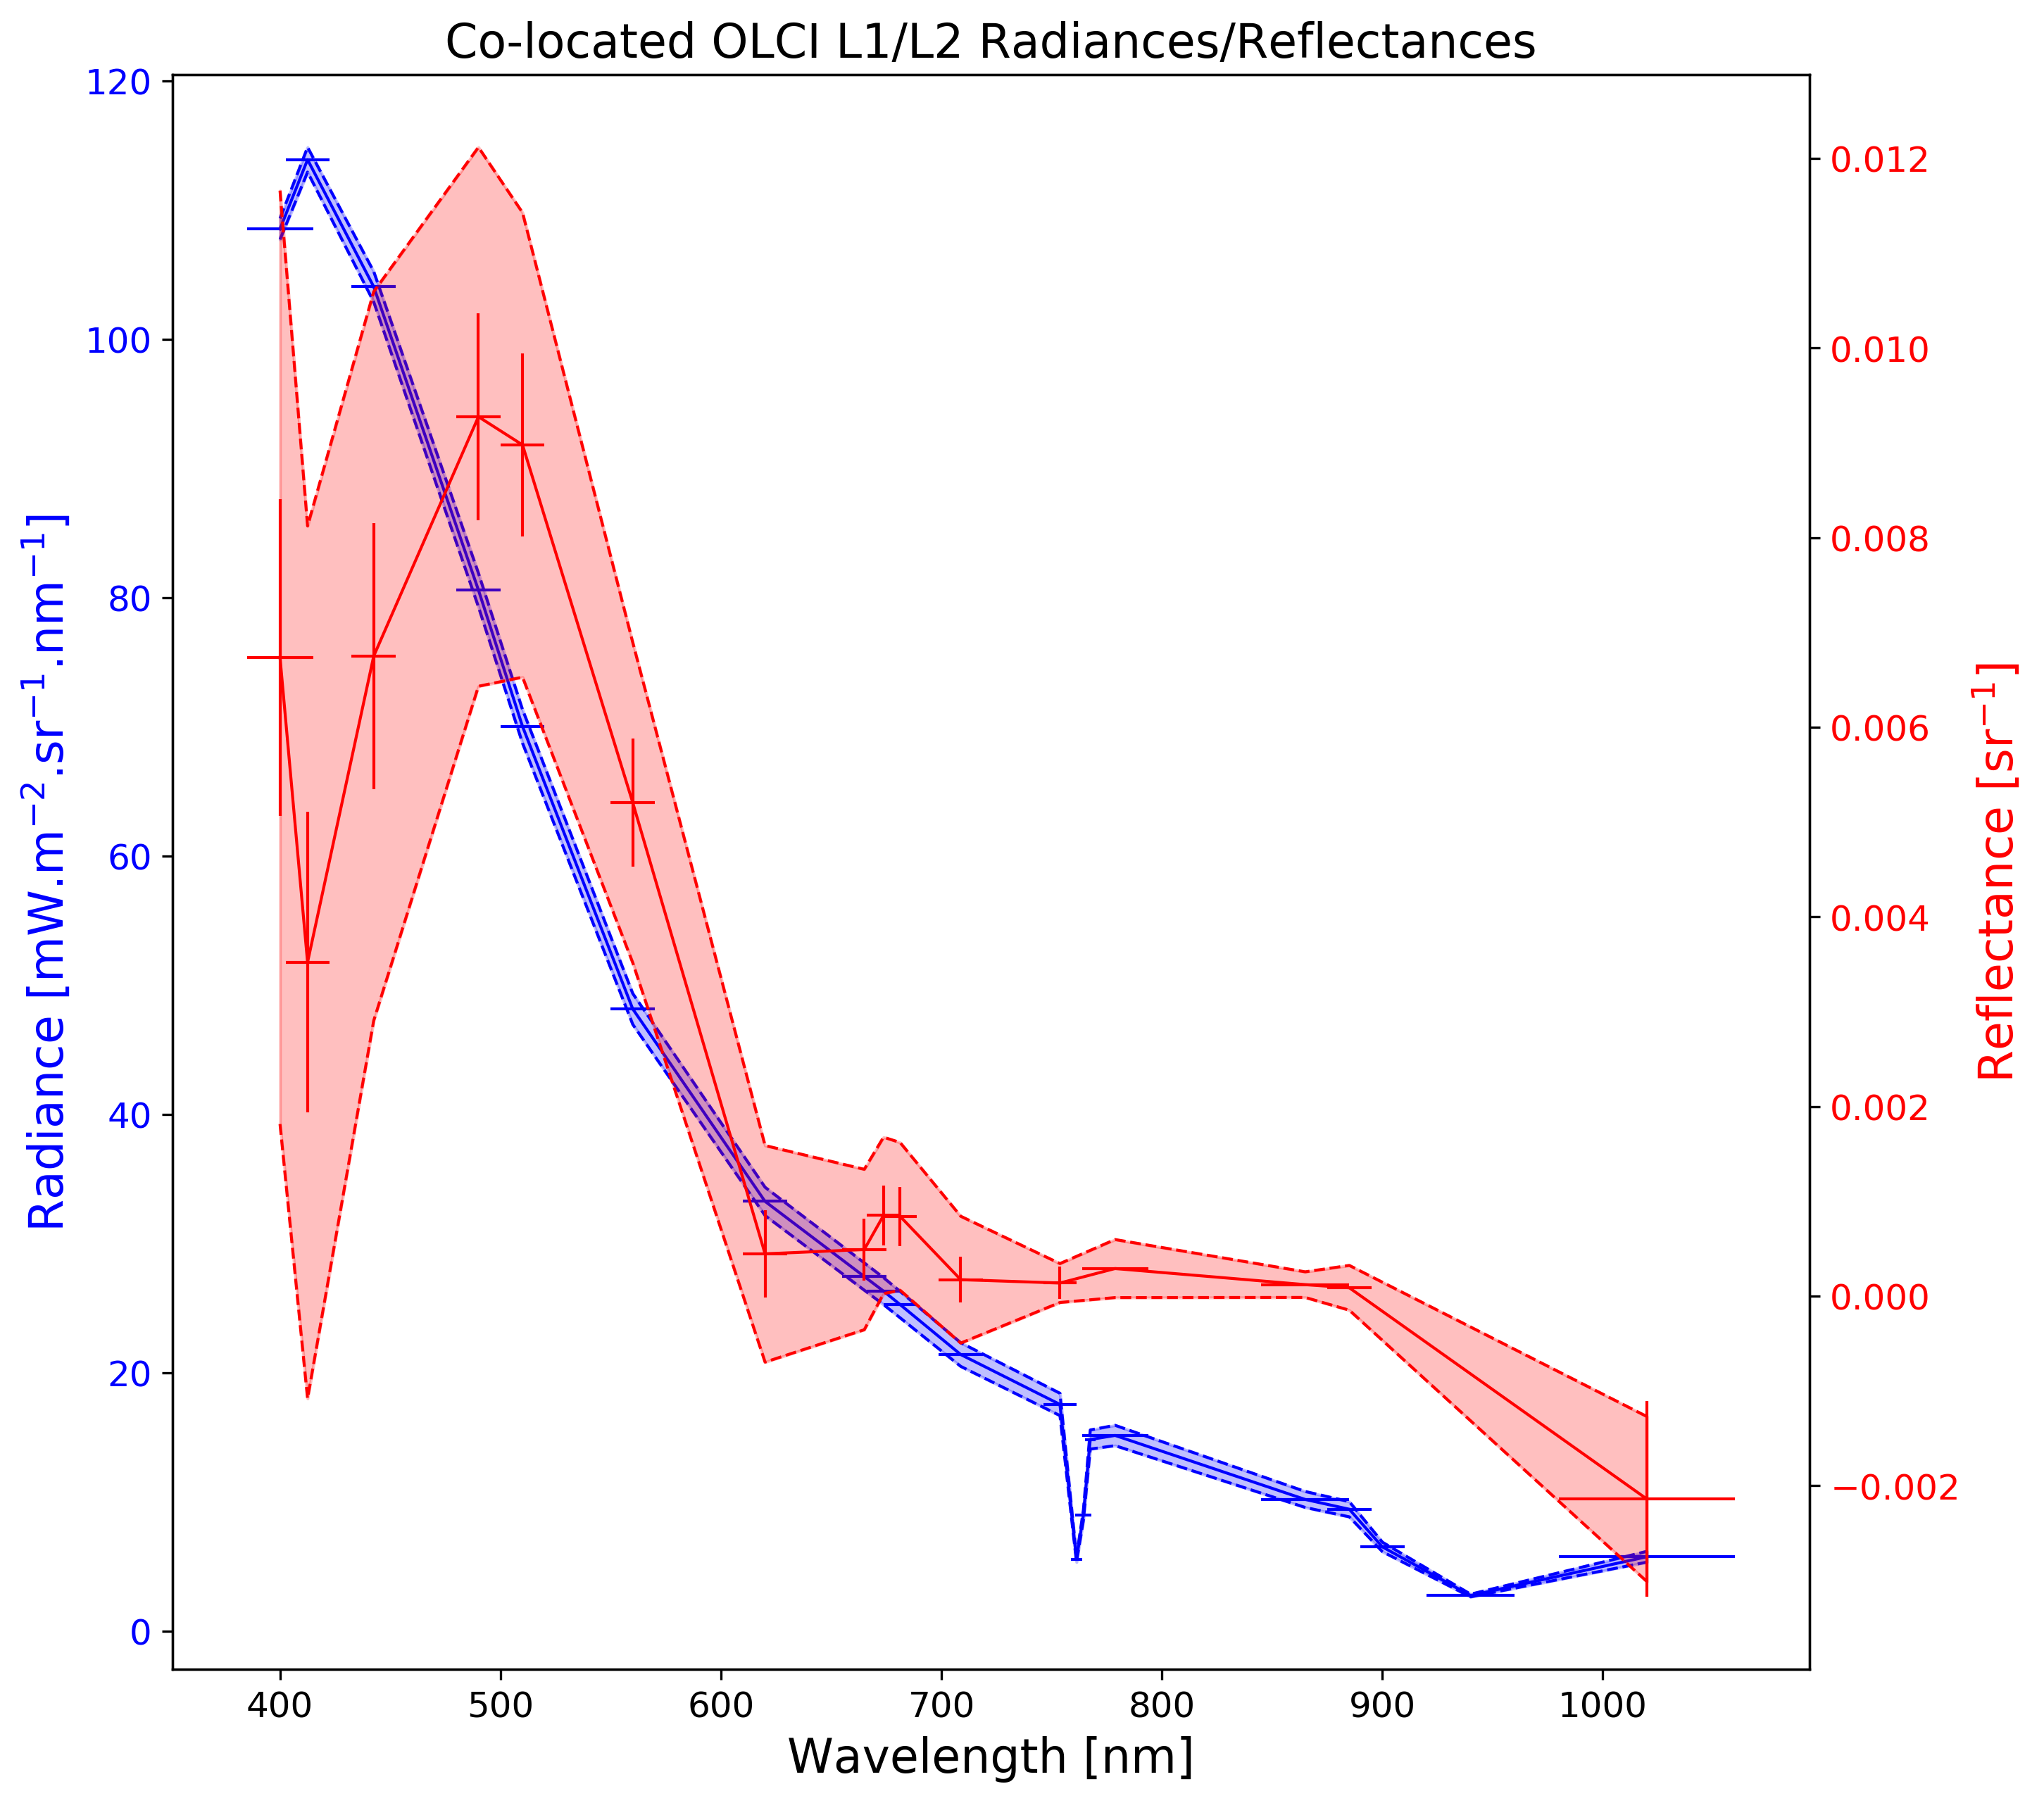

In [13]:
# print the spectra
fig1 = plt.figure(figsize=(10, 10), dpi=300)

plt.errorbar(wavelengths_L1, radiances, xerr=bandwidths_L1, yerr=radiance_errors, color='b', linewidth=1.0)
plt.plot(wavelengths_L1,radiance_tops,'b--',linewidth=1.0)
plt.plot(wavelengths_L1,radiance_bottoms,'b--',linewidth=1.0)
plt.fill_between(wavelengths_L1,radiance_tops,radiance_bottoms,color='b',alpha=0.25)
plt.xlabel('Wavelength [nm]', fontsize=16)
plt.ylabel('Radiance [mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$]', fontsize=16, color='b')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, color='b')

ax1 = plt.twinx()
plt.errorbar(wavelengths_L2, reflectances, xerr=bandwidths_L2, yerr=reflectance_errors, color='r', linewidth=1.0)
plt.plot(wavelengths_L2,reflectance_tops,'r--',linewidth=1.0)
plt.plot(wavelengths_L2,reflectance_bottoms,'r--',linewidth=1.0)
plt.fill_between(wavelengths_L2,reflectance_tops,reflectance_bottoms,color='r',alpha=0.25)
plt.xlabel('Wavelength [nm]', fontsize=16)
plt.ylabel('Reflectance [sr$^{-1}$]', fontsize=16, color='r')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, color='r')
plt.title('Co-located OLCI L1/L2 Radiances/Reflectances', fontsize=16);

plt.show()

In [14]:
fig1.savefig('OLCI_spectra_AC_demo.png',bbox_inches='tight');

<br> <a href="./15_OLCI_CHL_comparison.ipynb"><< 15 - Ocean and Land Colour Instrument - CHL algorithm comparison</a><span style="float:right;"><a href="../SLSTR/21_SLSTR_spatial_interrogation.ipynb">21 - SLSTR spatial plotting, quality control and data interrogation >></a>  <hr> <p style="text-align:left;">This project is licensed under the <a href="/edit/LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab-usc-open/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>